In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [ ]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, get_str_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import pennylane_PQC_RZRXRZ_unique, qiskit_PQC_RZRXRZ_unique, qiskit_PQC_RXRZ_unique

from simulator.simulate import get_ideal_data_state, get_ideal_data_superpos, run_sampler_pennylane
from models.pennylane_models import SimplePennylaneQuantumStateModel
from models.noise_models import BitPhaseFlipNoise
from circuits.generate_circuits import GetGHZCircuitsForModel
from utils.loss_functions import QuantumFidelityLoss

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Apple GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 8
H_ON = 6
INPUT_BITS = '11010100'
EPOCHS = 6
# fakeVigo2_backend = FakeVigoV2()
# fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
# noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)
pqc_arch = pennylane_PQC_RZRXRZ_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = SimplePennylaneQuantumStateModel(
    num_qubits= NUM_QUBITS, num_params=NUM_QUBITS*3, pqc_arch_func=pqc_arch,   
    )

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
    )



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.0005)
loss_fn = QuantumFidelityLoss()
# loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_state(NUM_QUBITS, num_vals=int(10000))
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:06<00:00, 1562.79it/s]

256


In [9]:
param_list_epoch = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []
    epoch_param_snapshots = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        circuit = ghz_circuit_gen.get_noisy_model_circuit_params(params)
        measured = pqc_model(circuit=circuit)

        ideal = ideal.to(torch_device)
        measured = measured.to(torch_device)

        # print(ideal)
        # print(measured)

        # Compute fidelity loss
        # print(ideal)
        # print(measured)
        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out

        loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        epoch_param_snapshots.append(raw_param_values)
        epoch_loss_list.append(loss.item())

        data_iterator.set_postfix_str(f"Loss: {loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            # bounded = pqc_model.raw_params.detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            # print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")

# Optional: print debug stats
        # if enable_debug_logs and step == len(data_iterator) - 1:
        #     print(circuit.draw())
        #     print(measured)
        #     print(ideal)
        #     print(loss)

    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)
    param_list_epoch.extend(np.array(epoch_param_snapshots))

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

        


 Starting Epoch 1


  0%|          | 3/10000 [00:00<06:41, 24.87it/s, Loss: 9.9997e-01]

	Step 0, grad norm: 9.4771e-03
	Raw param range: [-11.057, 16.509]


100%|██████████| 10000/10000 [06:24<00:00, 26.03it/s, Loss: 5.7268e-02]


Epoch 1 complete: avg loss = 6.8390e-01

 Starting Epoch 2


  0%|          | 3/10000 [00:00<06:25, 25.95it/s, Loss: 8.5276e-02]

	Step 0, grad norm: 1.1965e-01
	Raw param range: [-12.675, 18.620]


100%|██████████| 10000/10000 [06:20<00:00, 26.25it/s, Loss: 1.2031e-01]


Epoch 2 complete: avg loss = 7.7207e-02

 Starting Epoch 3


  0%|          | 3/10000 [00:00<06:40, 24.93it/s, Loss: 8.4917e-02]

	Step 0, grad norm: 1.1718e-01
	Raw param range: [-12.736, 18.621]


100%|██████████| 10000/10000 [06:28<00:00, 25.74it/s, Loss: 5.4517e-02]


Epoch 3 complete: avg loss = 7.2609e-02

 Starting Epoch 4


  0%|          | 3/10000 [00:00<06:32, 25.48it/s, Loss: 1.2017e-01]

	Step 0, grad norm: 1.5461e-01
	Raw param range: [-12.768, 18.634]


100%|██████████| 10000/10000 [06:34<00:00, 25.36it/s, Loss: 5.3140e-02]


Epoch 4 complete: avg loss = 7.1797e-02

 Starting Epoch 5


  0%|          | 3/10000 [00:00<07:00, 23.77it/s, Loss: 1.3542e-01]

	Step 0, grad norm: 1.0049e-01
	Raw param range: [-12.770, 18.629]


100%|██████████| 10000/10000 [06:39<00:00, 25.00it/s, Loss: 4.9949e-02]


Epoch 5 complete: avg loss = 7.1692e-02

 Starting Epoch 6


  0%|          | 3/10000 [00:00<06:21, 26.21it/s, Loss: 6.3281e-02]

	Step 0, grad norm: 1.5801e-01
	Raw param range: [-12.770, 18.626]


100%|██████████| 10000/10000 [06:38<00:00, 25.08it/s, Loss: 7.4309e-02]

Epoch 6 complete: avg loss = 7.1662e-02


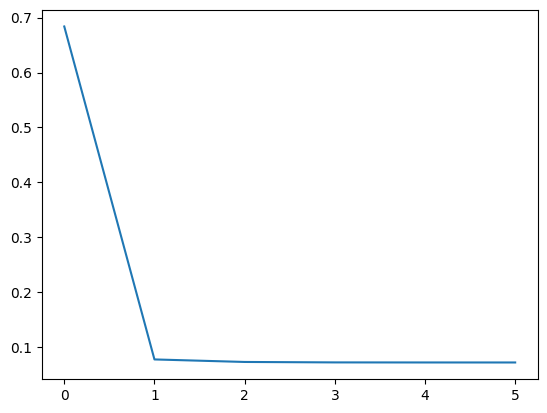

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
print(pqc_model.raw_params)

Parameter containing:
tensor([ 3.0929e+00, -6.0726e+00,  3.0888e+00,  6.1648e+00,  1.8631e+01,
         1.5911e-02, -1.1407e-01,  6.0666e+00, -6.2666e+00, -6.2662e+00,
        -6.4897e+00, -1.1681e-01,  9.3456e-02, -1.2770e+01,  1.2365e+01,
        -6.3304e+00,  6.0725e+00, -6.3287e+00, -3.3542e+00,  1.6936e+00,
         3.0070e+00, -5.4442e-02, -2.0979e-01, -4.7830e-02],
       requires_grad=True)


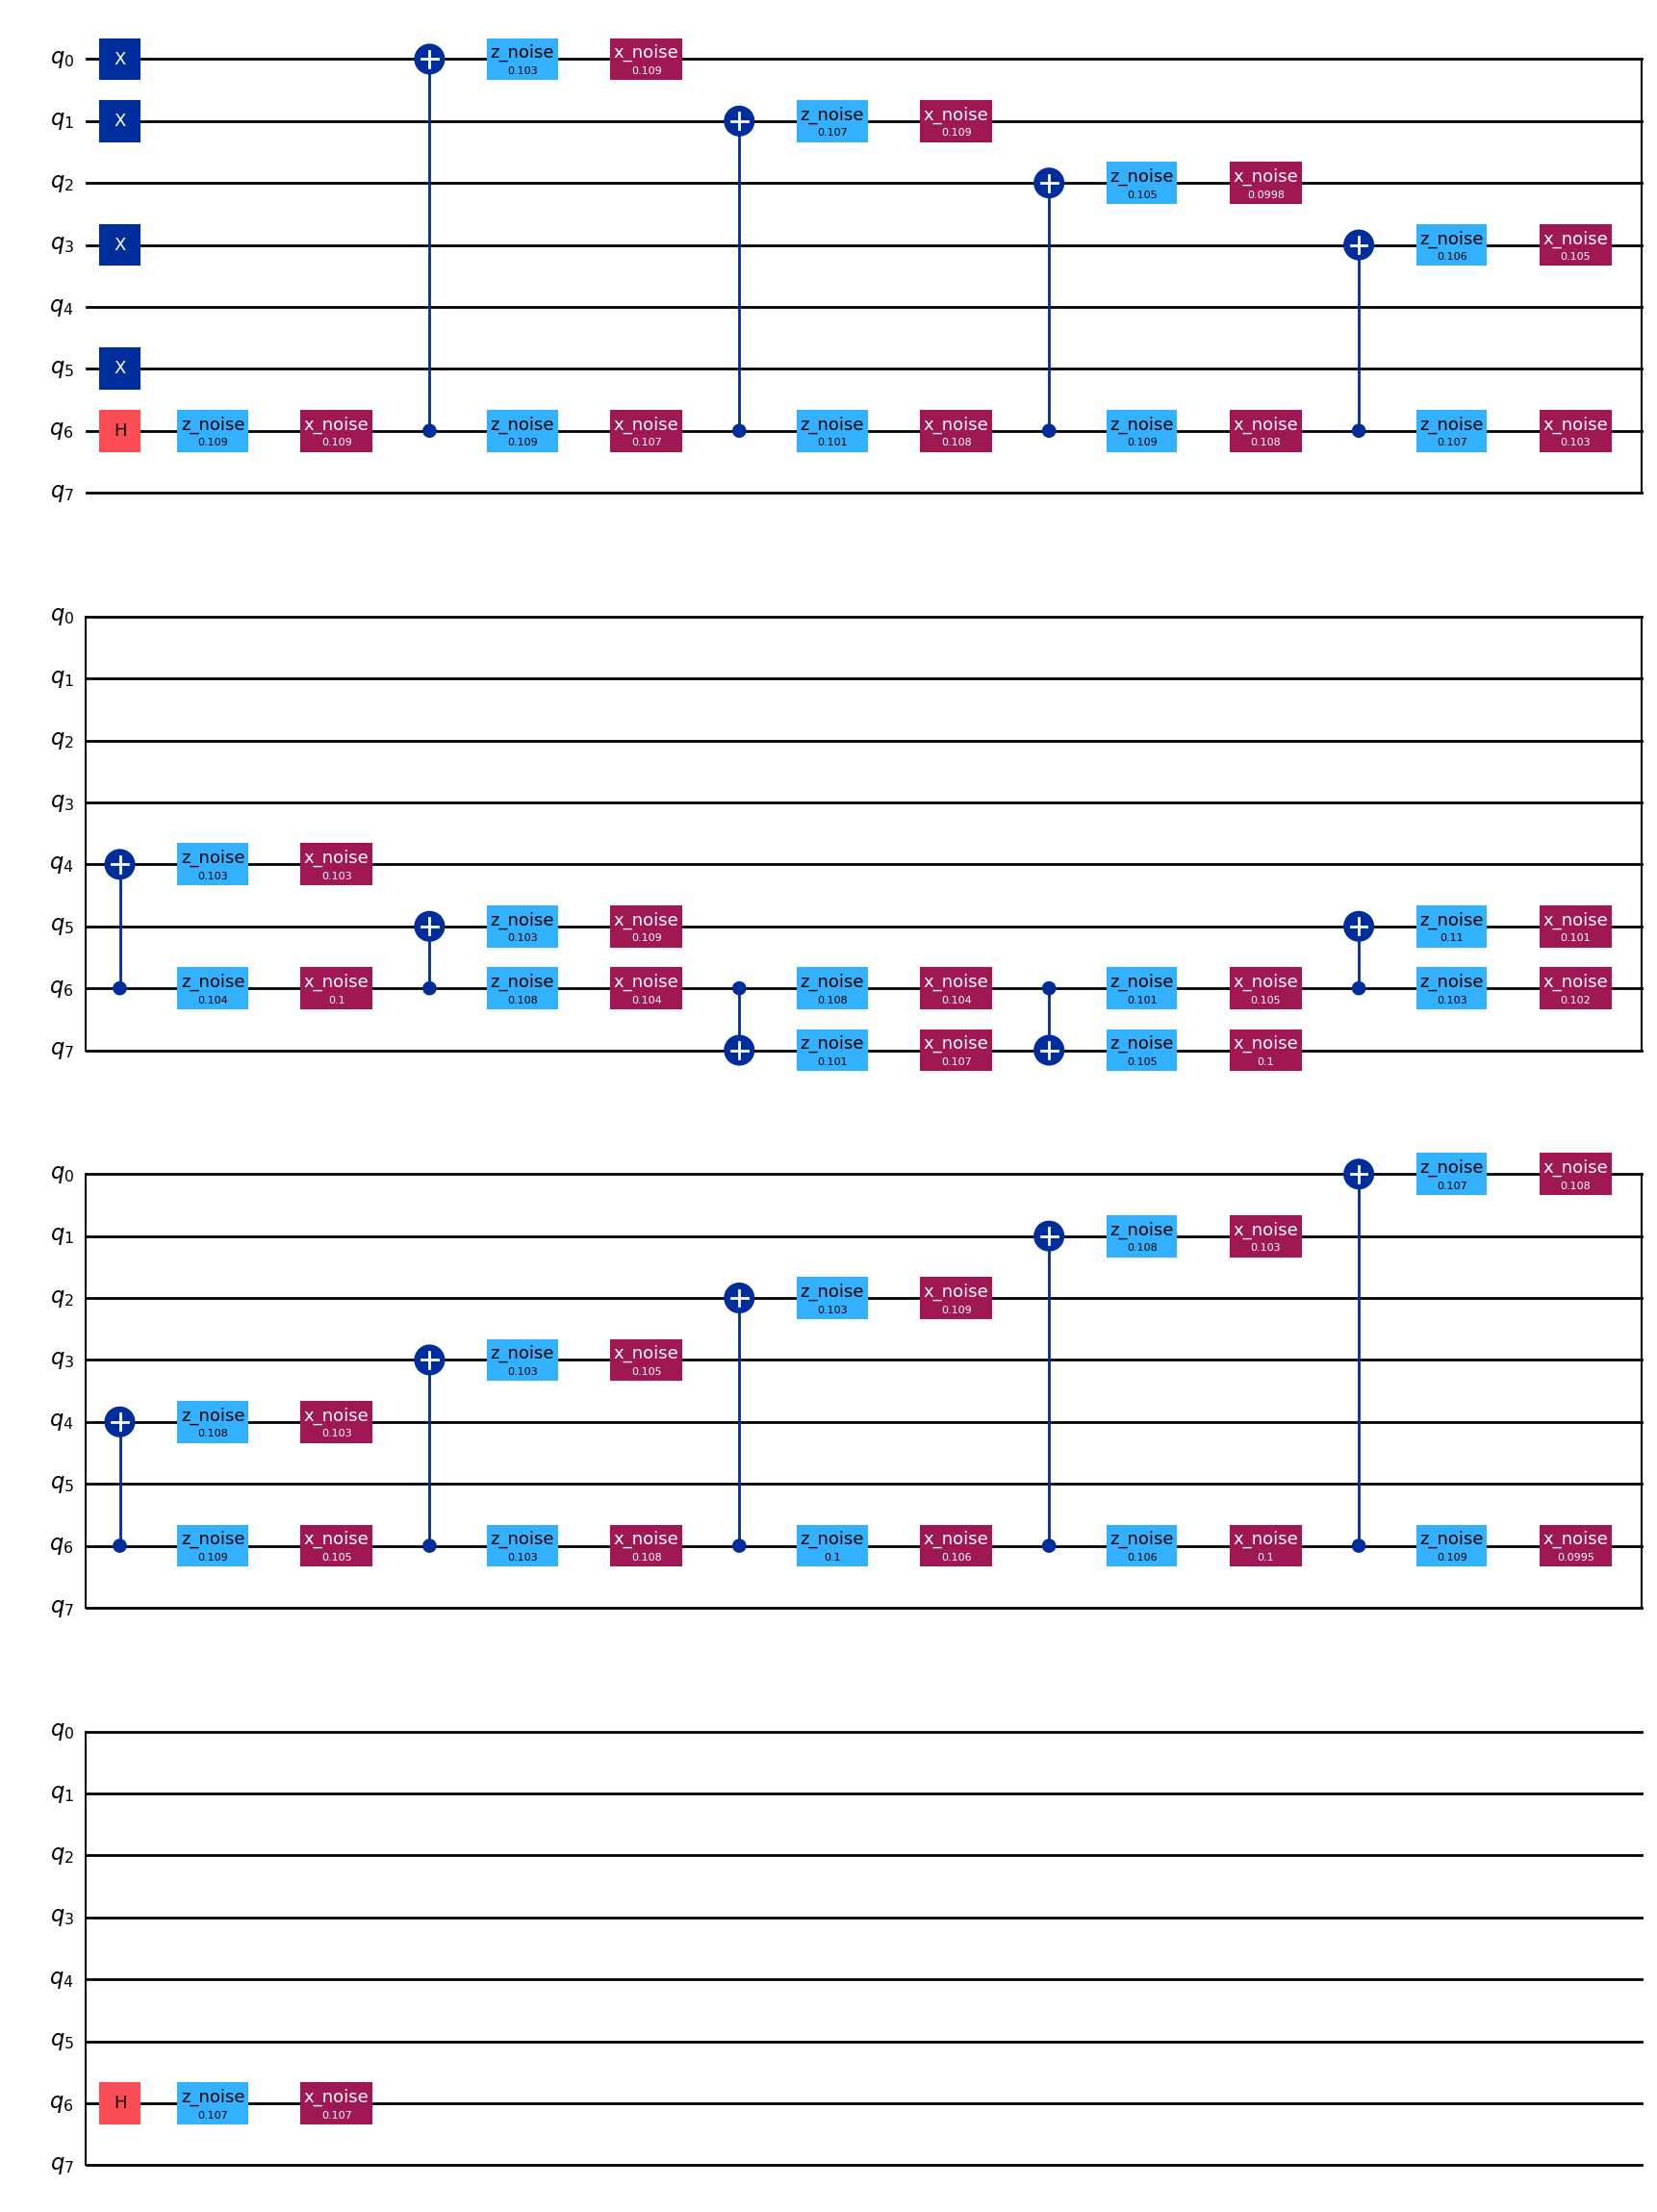

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

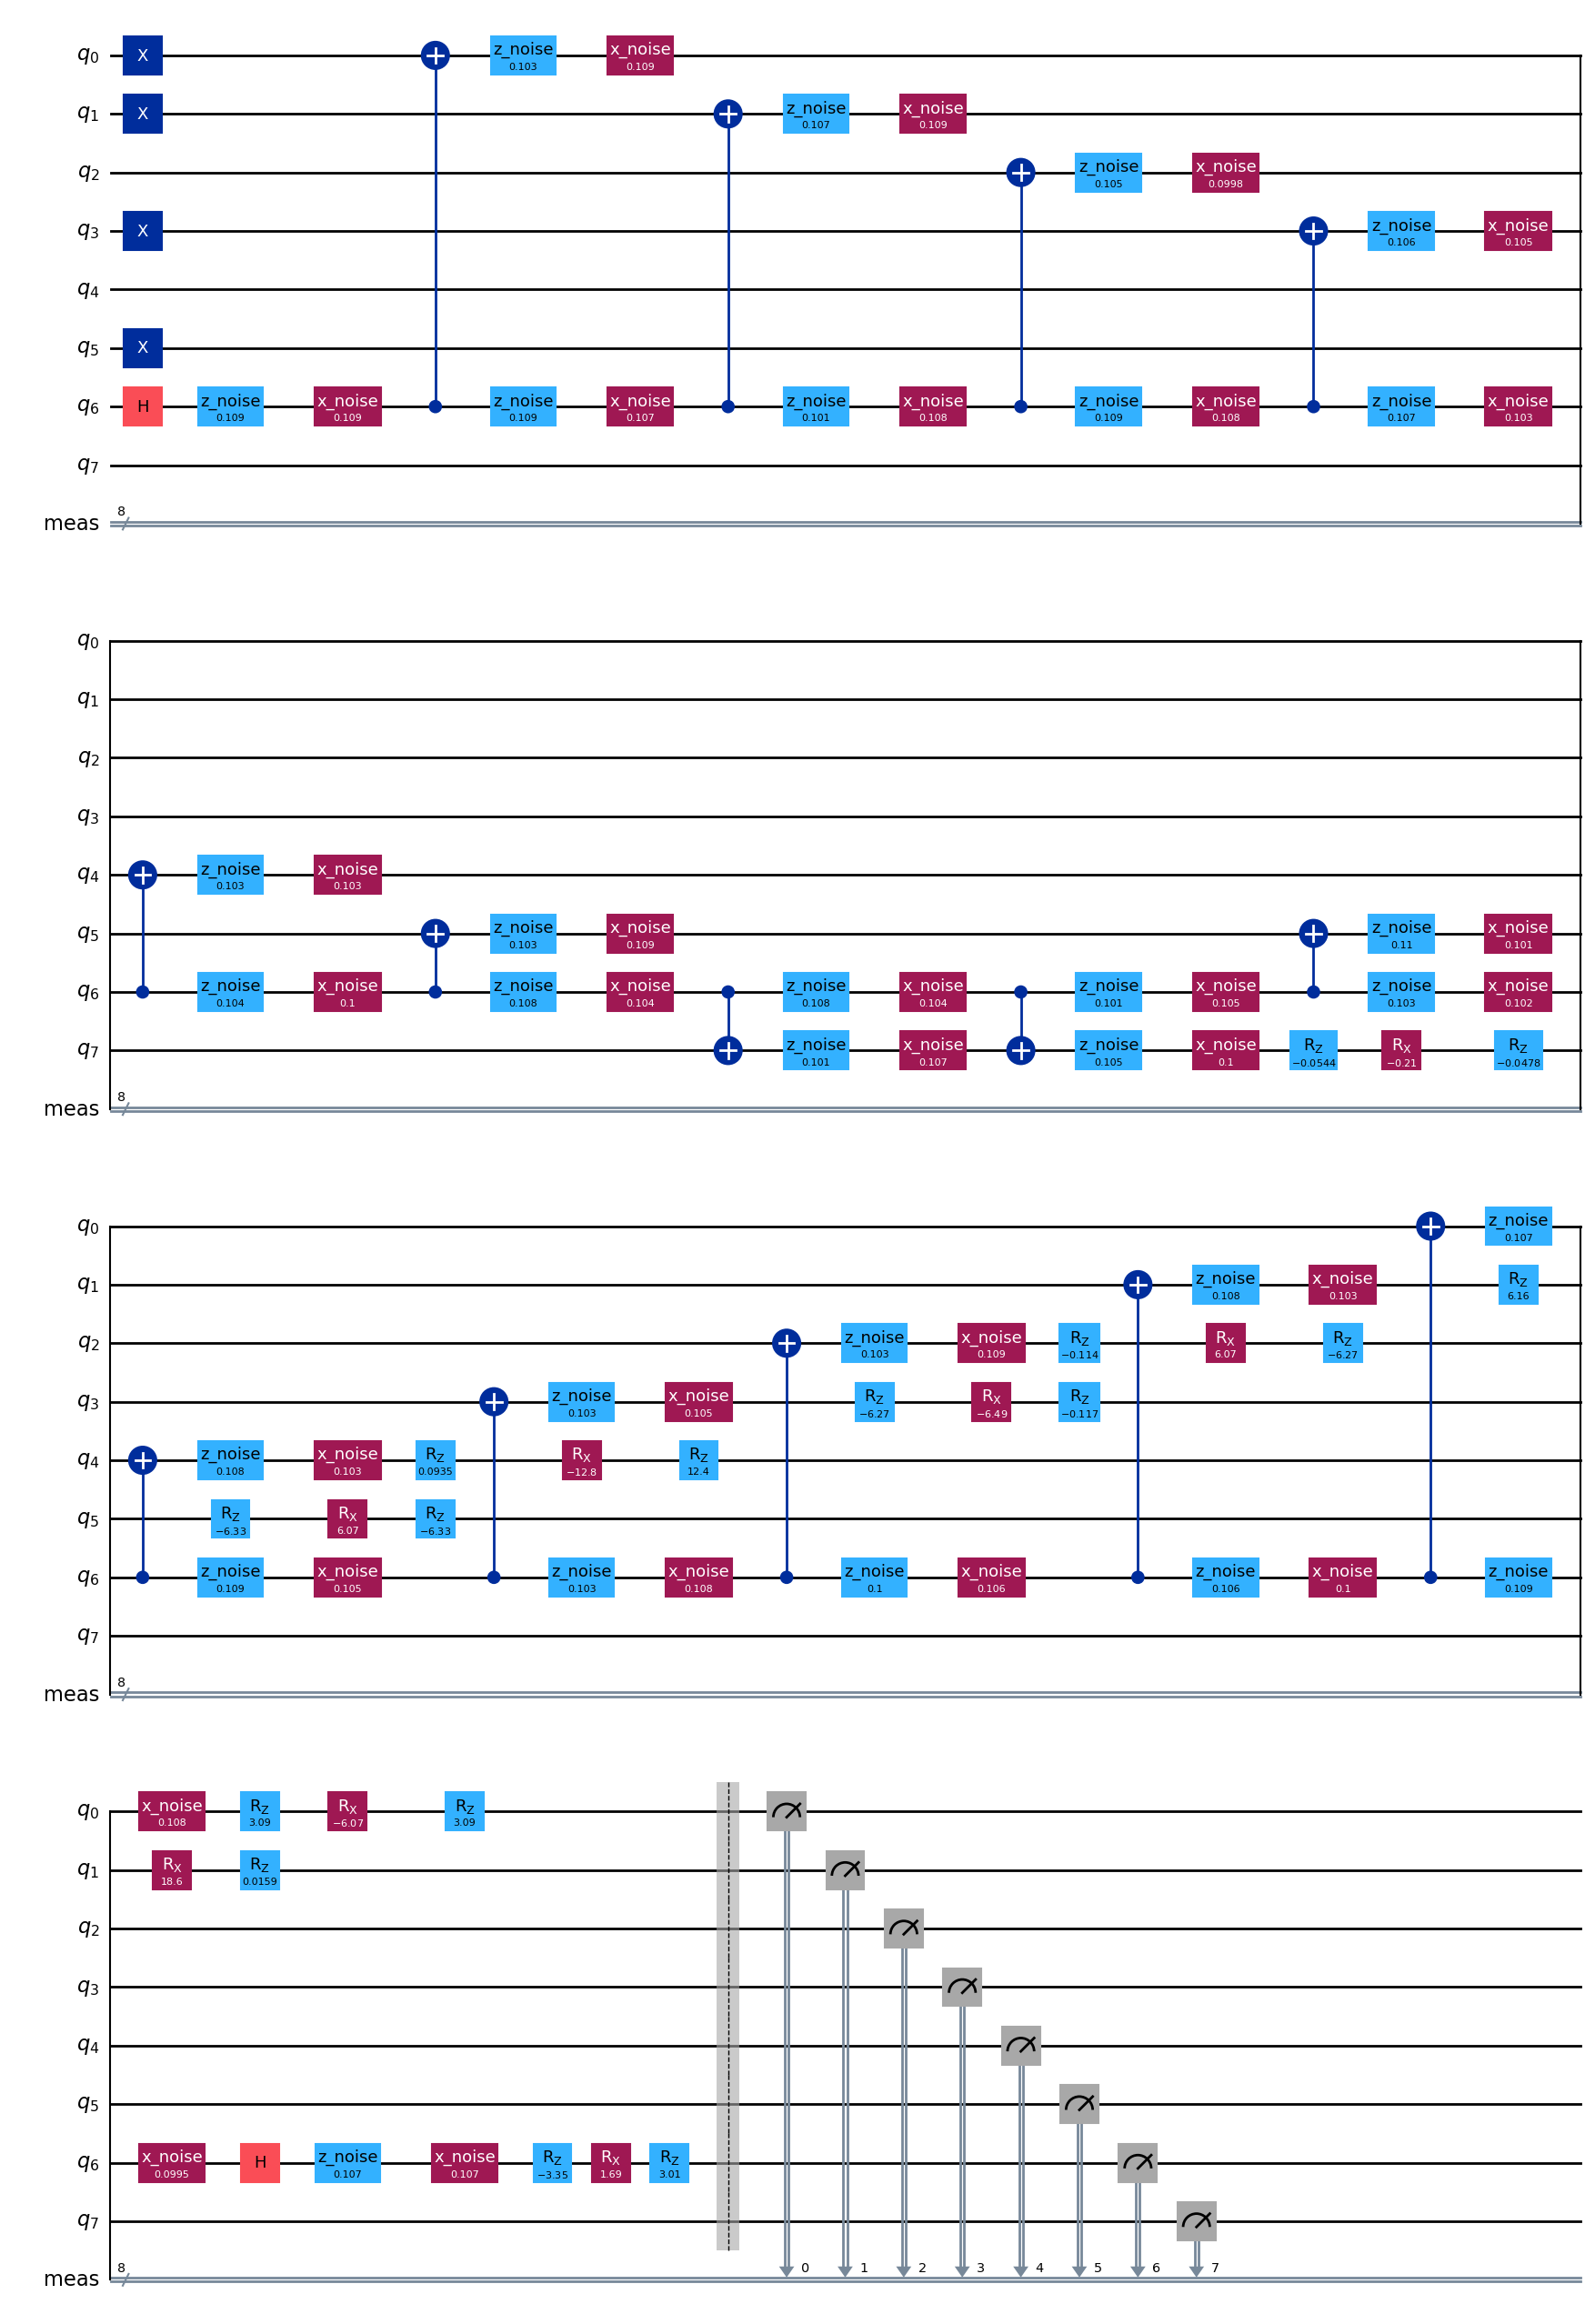

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, qiskit_PQC_RZRXRZ_unique)
noisy_model_circ_pqc.draw('mpl')

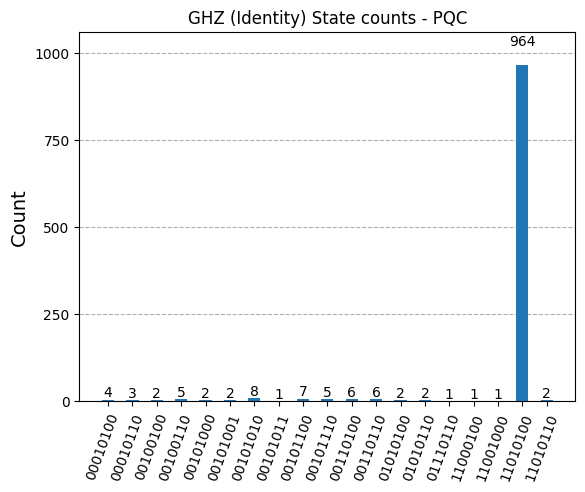

In [ ]:
# transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
# result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
# counts = result.get_counts(transpiled_circ)

counts = run_sampler_pennylane(noisy_model_circ_pqc)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

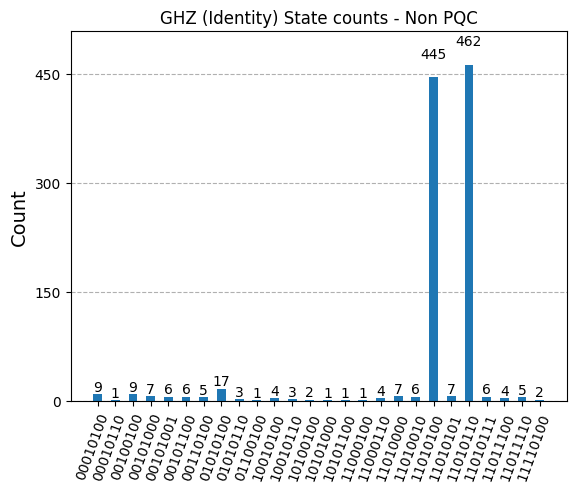

In [ ]:
# transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
# result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
# counts = result.get_counts(transpiled_circ)


counts = run_sampler_pennylane(noisy_model_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

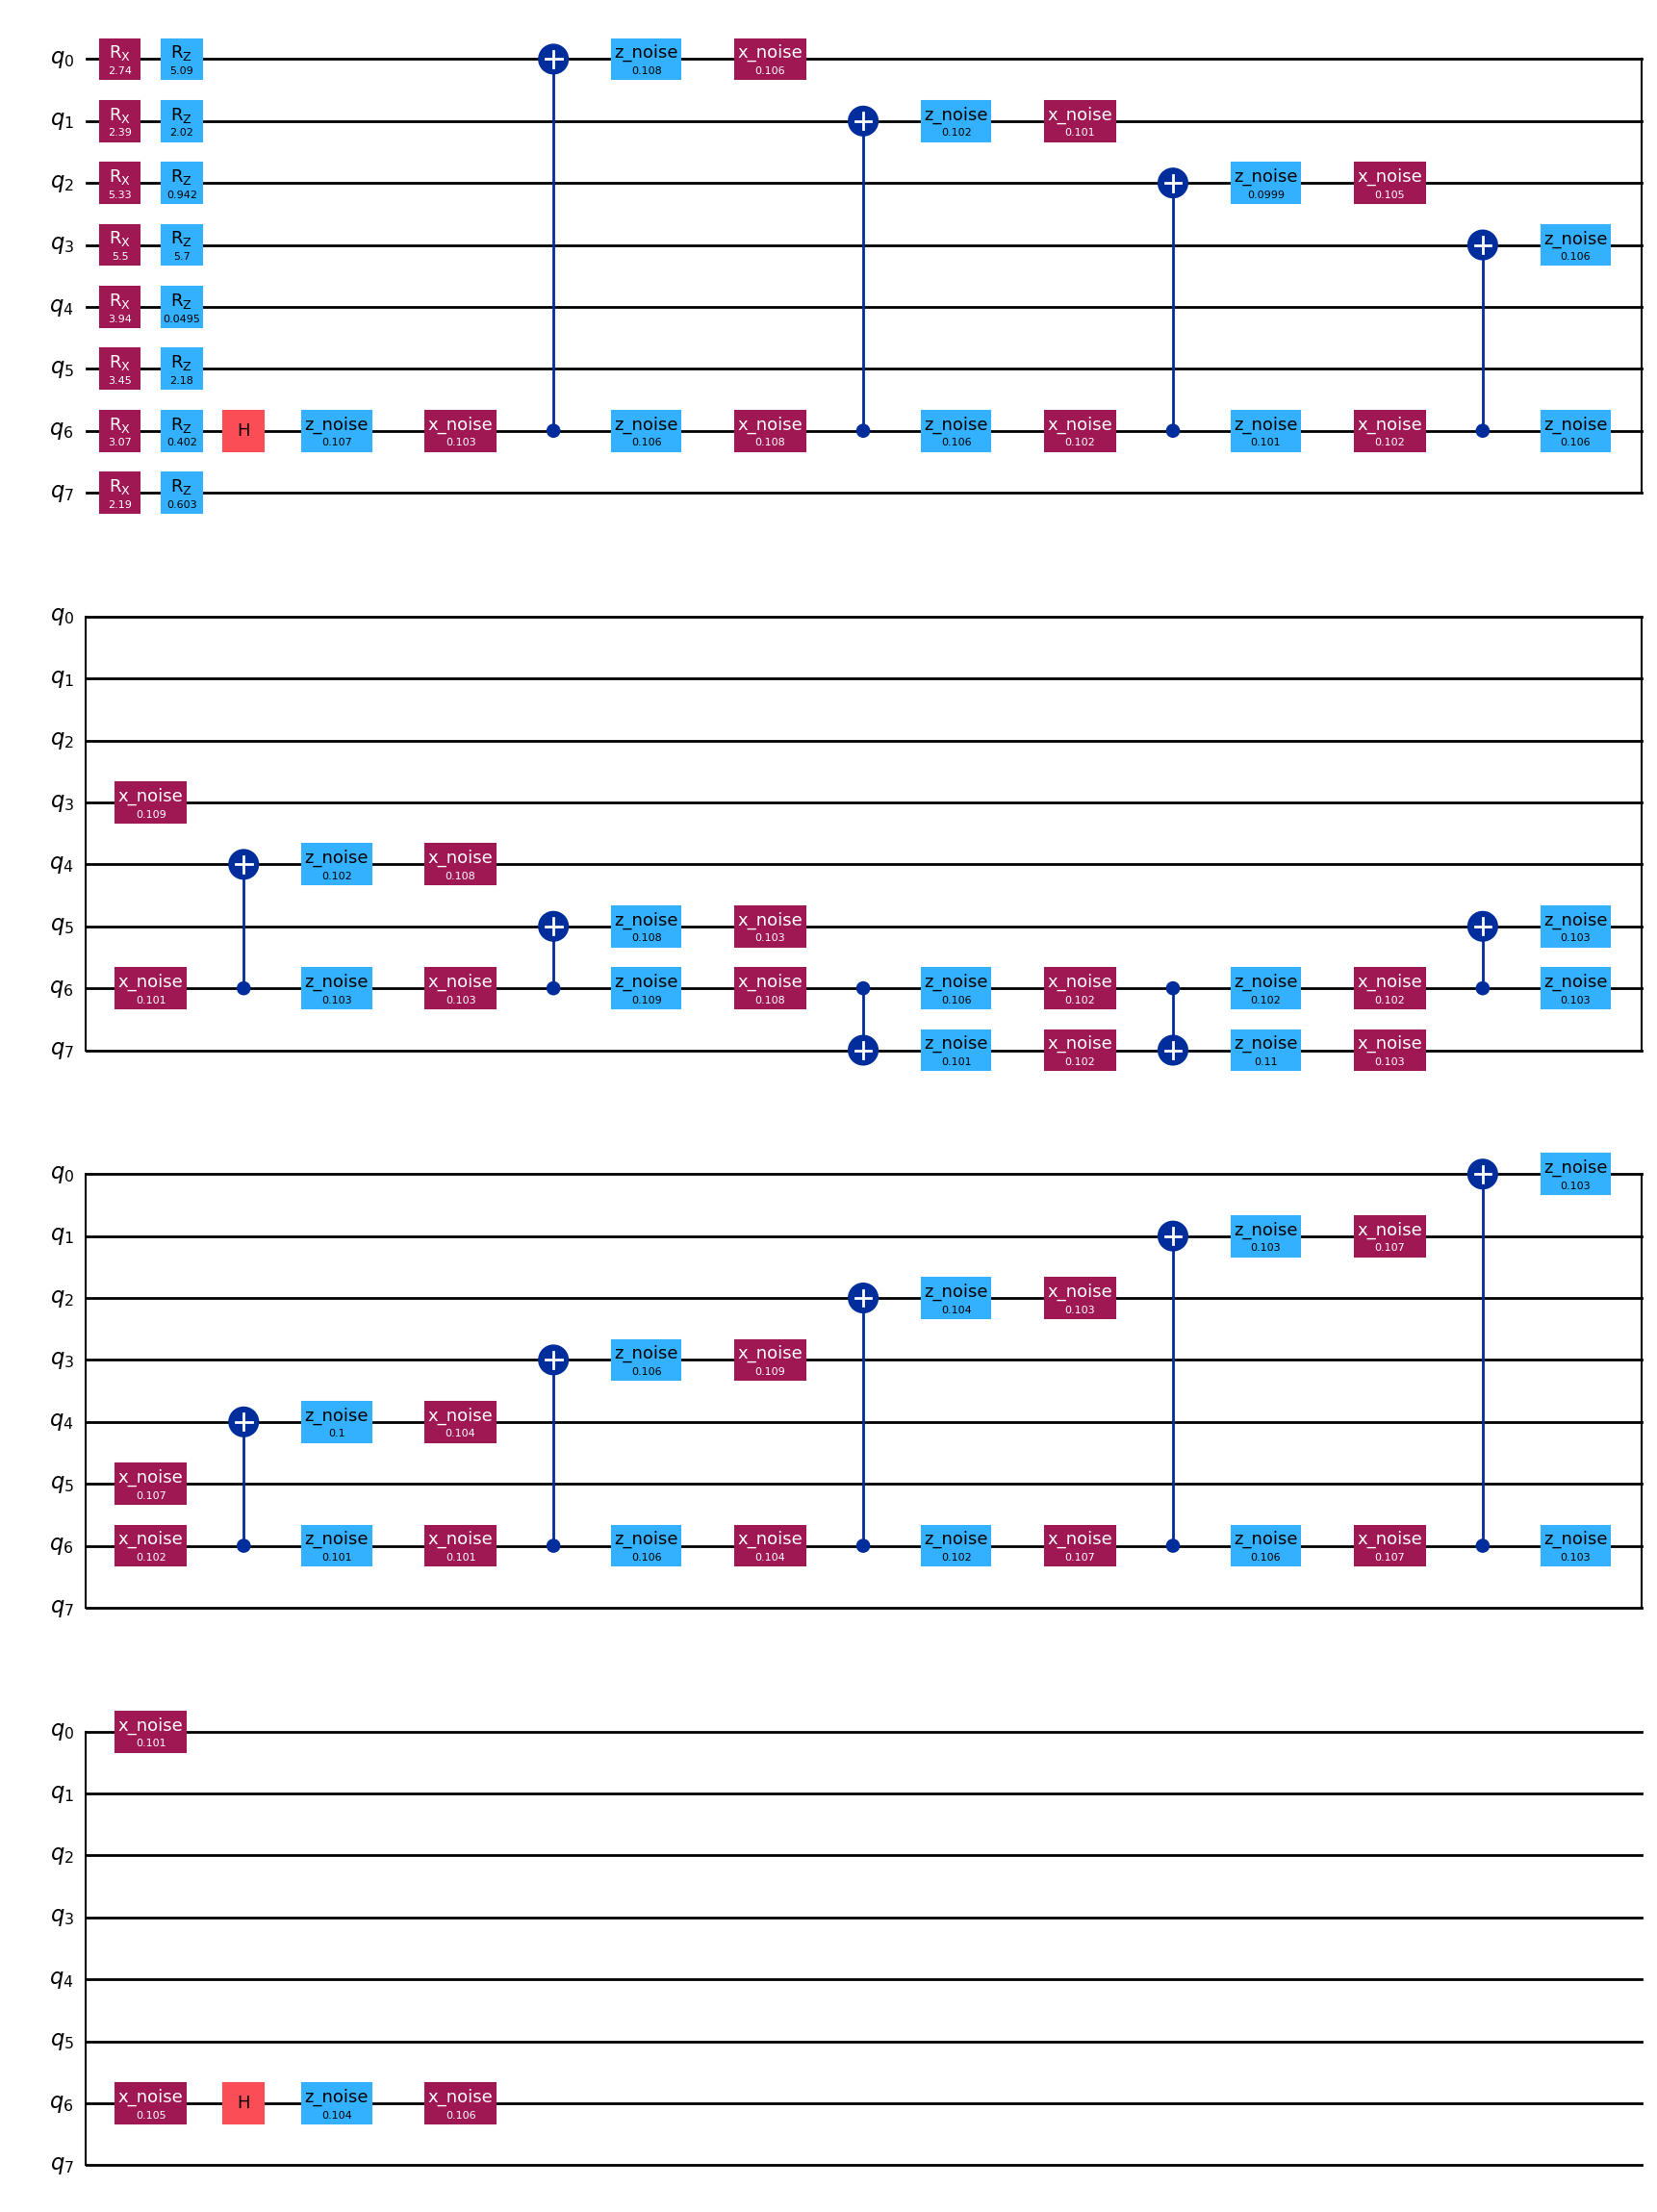

In [16]:
circuit.draw('mpl')

In [17]:
from qiskit.quantum_info import Statevector

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def state_fidelity(psi: torch.Tensor, phi: torch.Tensor) -> torch.Tensor:
    """
    Compute fidelity F = |⟨ψ|φ⟩|² between two normalized state vectors.

    Args:
        psi (torch.Tensor): Complex tensor of shape (2**n,) representing |ψ⟩
        phi (torch.Tensor): Complex tensor of shape (2**n,) representing |φ⟩

    Returns:
        torch.Tensor: Real-valued scalar fidelity
    """
    # Optional: normalize if needed
    psi = psi / torch.linalg.norm(psi)
    phi = phi / torch.linalg.norm(phi)

    overlap = torch.dot(torch.conj(psi), phi)
    return torch.abs(overlap) ** 2

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, num_vals=20, statevector=True)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, qiskit_PQC_RZRXRZ_unique)

    noi_out_st = torch.tensor(Statevector.from_instruction(noisy_circ.remove_final_measurements(inplace=False)).data)
    npqc_out_st = torch.tensor(Statevector.from_instruction(noisy_circ_pqc.remove_final_measurements(inplace=False)).data)
    
    

    fid_i_n = state_fidelity(ideal, noi_out_st)
    fid_i_ne = state_fidelity(ideal, npqc_out_st)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 2484.48it/s]


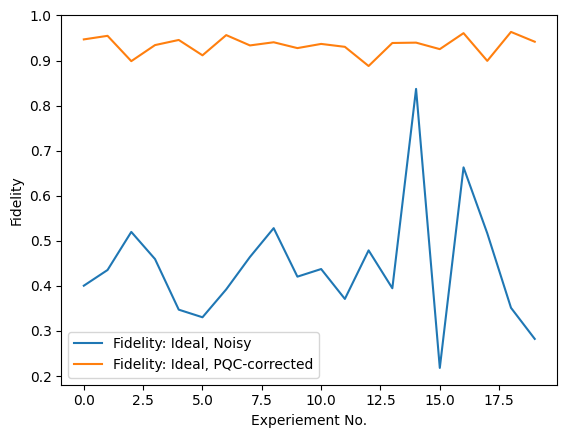

In [18]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [19]:
print(f"Avg Fidelity of noisy circuit: {np.mean(fid_noisy)}, Average Fidelity of noisy circ with PQC: {np.mean(fid_noisy_pqc)}")

Avg Fidelity of noisy circuit: 0.44234786259692027, Average Fidelity of noisy circ with PQC: 0.9337045064894551


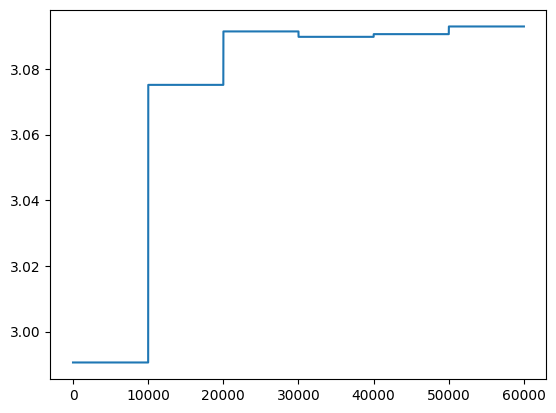

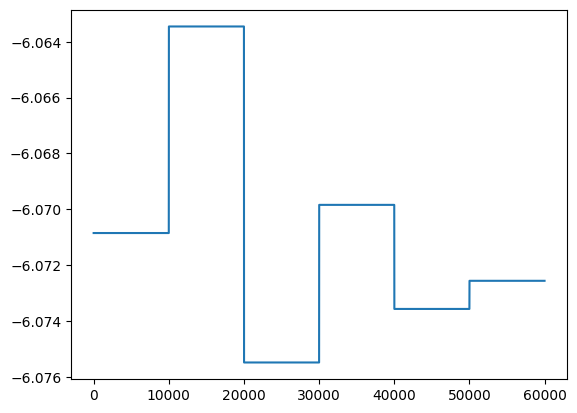

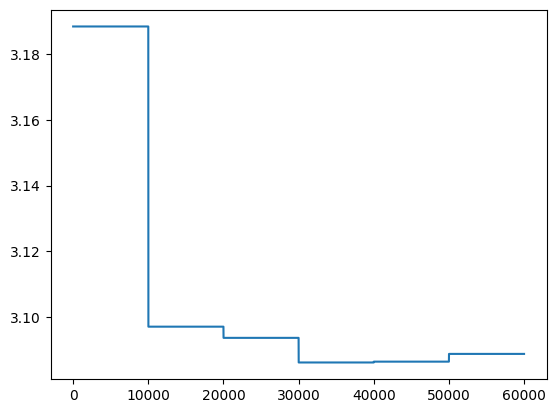

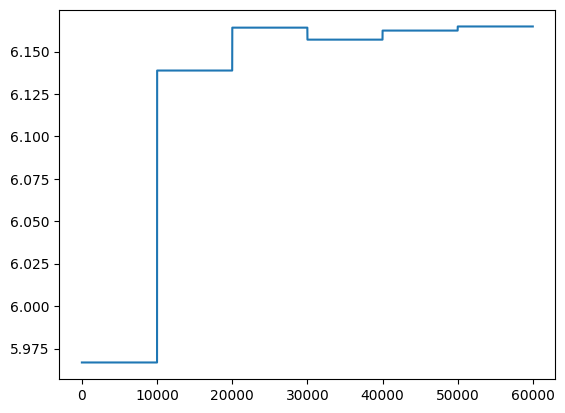

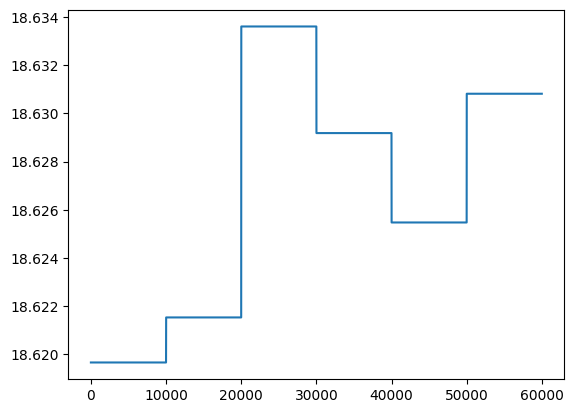

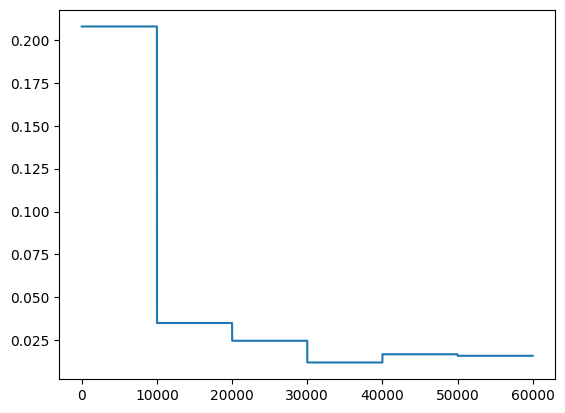

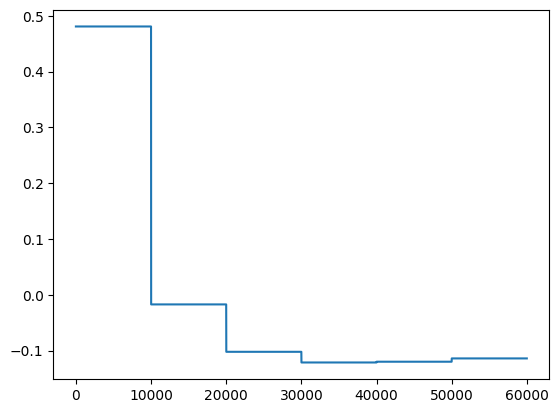

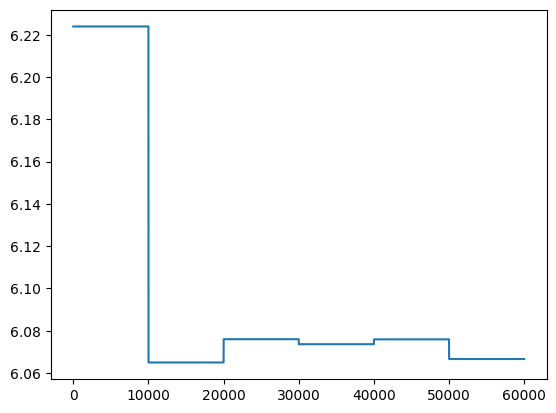

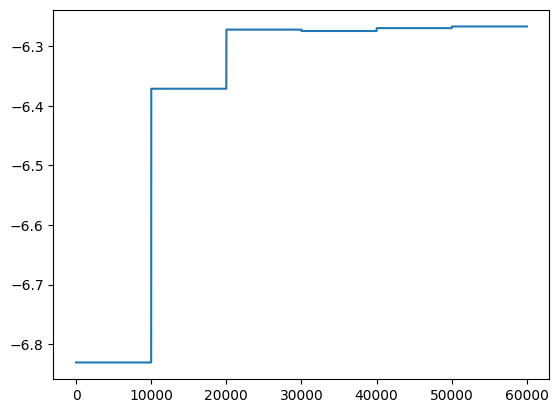

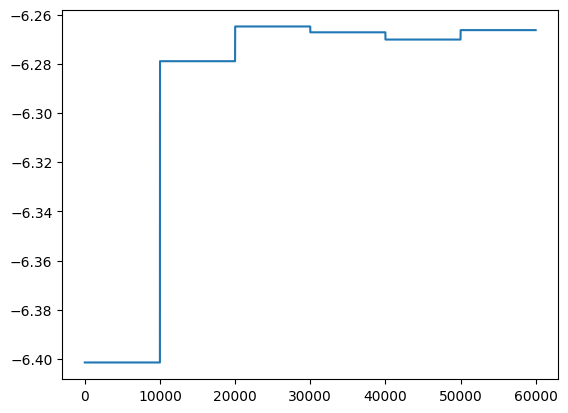

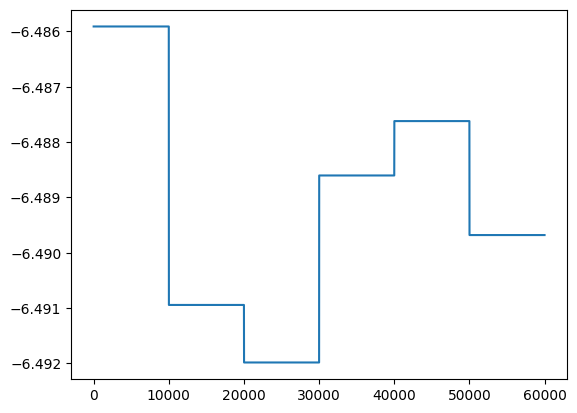

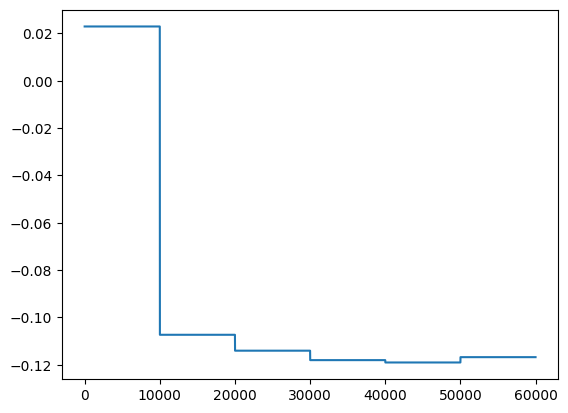

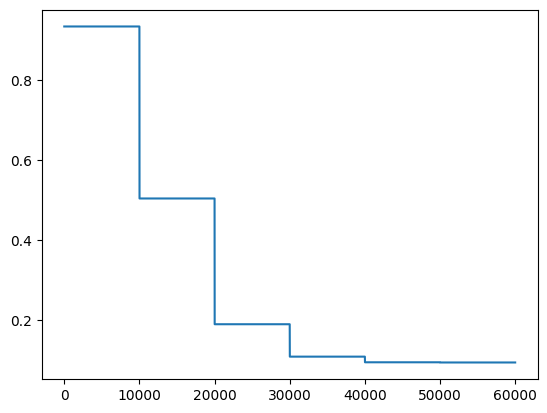

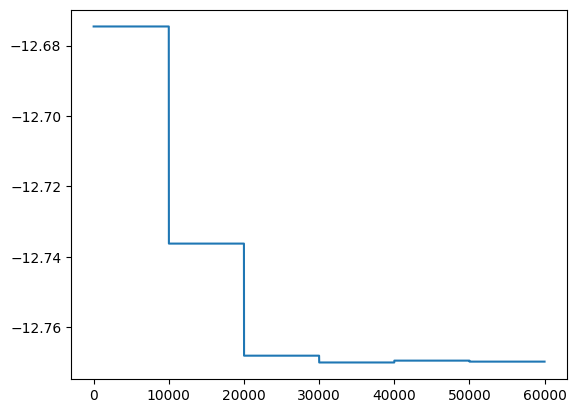

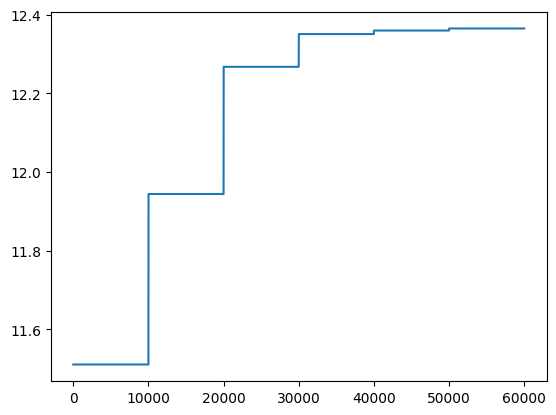

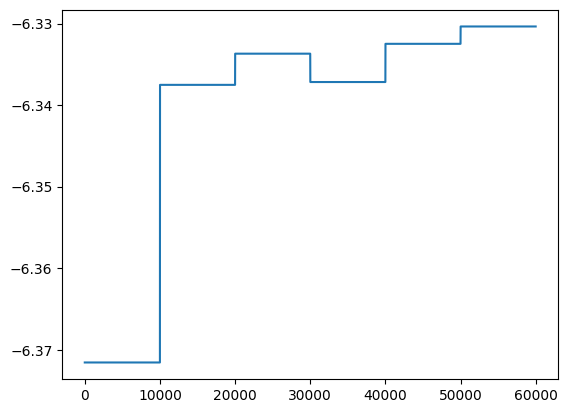

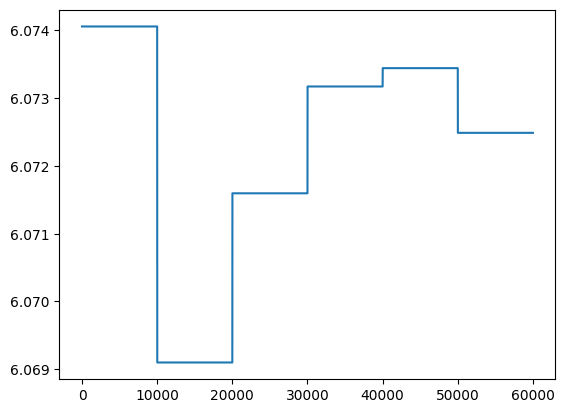

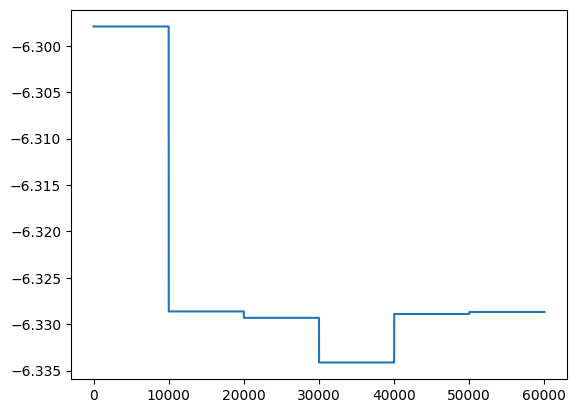

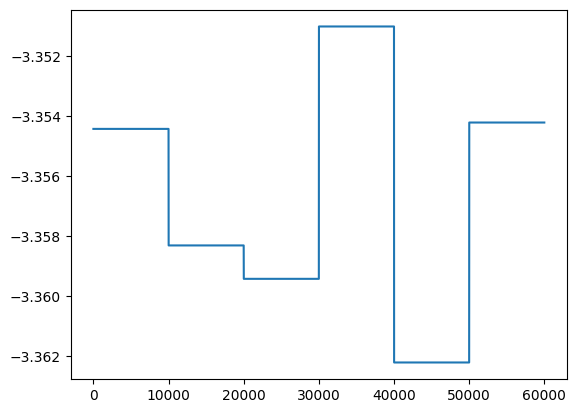

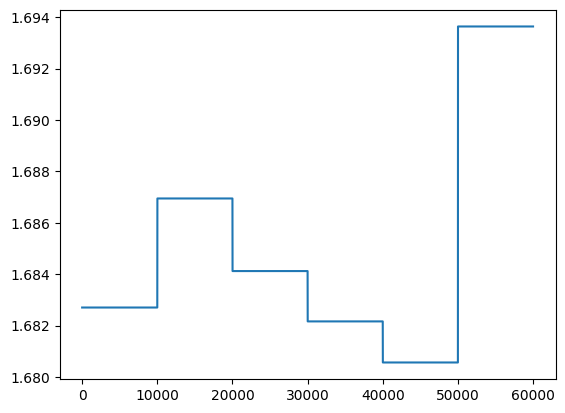

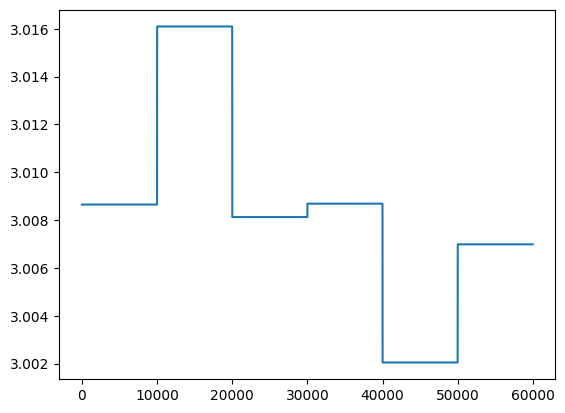

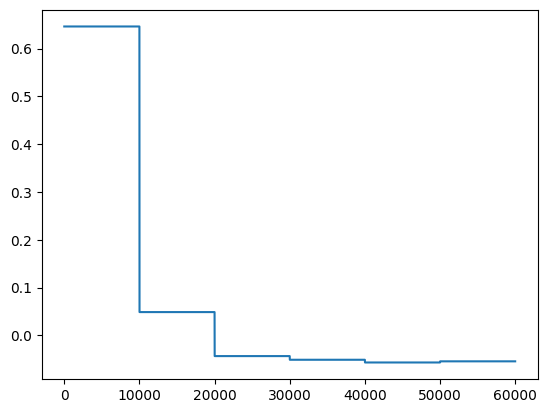

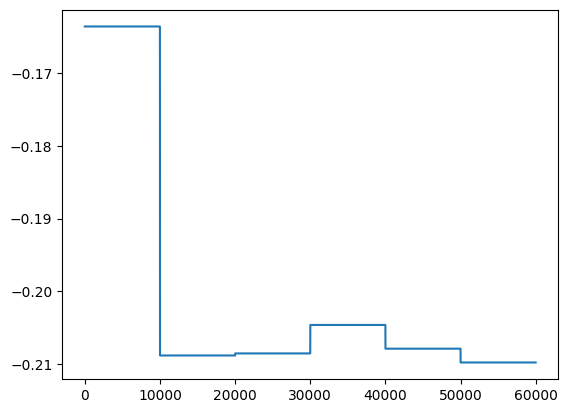

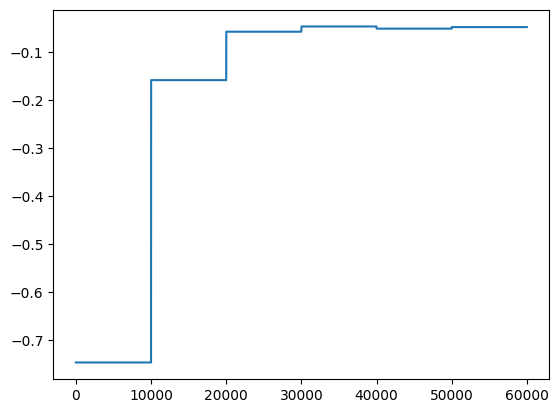

In [20]:
param_arr = np.array(param_list_epoch).transpose()
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()

In [21]:
print(ideal_data[0])

(array([[2.7295496 , 2.3286076 ],
       [1.1674695 , 1.8830386 ],
       [1.6885066 , 1.2221112 ],
       [0.27108654, 0.8708049 ],
       [4.392209  , 2.1110737 ],
       [1.0924456 , 1.2616023 ],
       [0.6987642 , 1.5396845 ],
       [4.8126397 , 1.1801207 ]], dtype=float32), tensor([ 3.9018e-02+3.3113e-03j, -3.3772e-02+1.0670e-02j,
         1.4246e-02+7.6363e-04j, -1.2177e-02+4.2682e-03j,
         2.3208e-02-5.3002e-03j, -1.7583e-02+1.2426e-02j,
         8.3911e-03-2.1931e-03j, -6.2622e-03+4.7242e-03j,
        -4.3988e-02-3.1733e-02j,  4.7718e-02+1.1388e-02j,
        -1.6378e-02-1.1057e-02j,  1.7506e-02+3.6061e-03j,
        -3.1343e-02-1.0239e-02j,  2.9739e-02-2.2325e-03j,
        -1.1530e-02-3.3734e-03j,  1.0804e-02-1.1500e-03j,
         4.3609e-03-3.0826e-03j, -2.5853e-03+4.0801e-03j,
         1.5531e-03-1.1720e-03j, -8.9521e-04+1.5151e-03j,
         1.9551e-03-2.5918e-03j, -7.4239e-04+2.8410e-03j,
         6.8259e-04-9.6598e-04j, -2.3814e-04+1.0430e-03j,
        -7.3764e-03+5.